# Load the LGMR data

In [15]:
import xarray as xr
# open the 'LGMR_GMST_ens.nc' file
ds_sat = xr.open_dataset('data/LGMR_SAT_ens.nc')
ds_sat

c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, age: 120, nEns: 500)
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * age      (age) float32 100.0 300.0 500.0 ... 2.35e+04 2.37e+04 2.39e+04
  * nEns     (nEns) float32 1.0 2.0 3.0 4.0 5.0 ... 497.0 498.0 499.0 500.0
Data variables:
    sat      (nEns, age, lat, lon) float32 ...

# Remove the data with age<11

In [16]:

ds_sat = ds_sat.where(ds_sat.age>=11000, drop=True)

c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


In [17]:
import numpy as np
weight = np.cos(np.deg2rad(ds_sat['lat']))

# set weight to 0 if it is smaller than 0
weight = xr.where(weight < 0, 0, weight)

ds_sat['weight']=weight

In [20]:
# store the ds_sat as a netcdf file
ds_sat_processed = ds_sat.to_netcdf('ens_ana_data/LGMR_SAT_ens_processed.nc')

In [2]:
# read the processed netcdf file
import xarray as xr
ds_sat_processed = xr.open_dataset('ens_ana_data/LGMR_SAT_ens_processed.nc')
ds_sat=ds_sat_processed

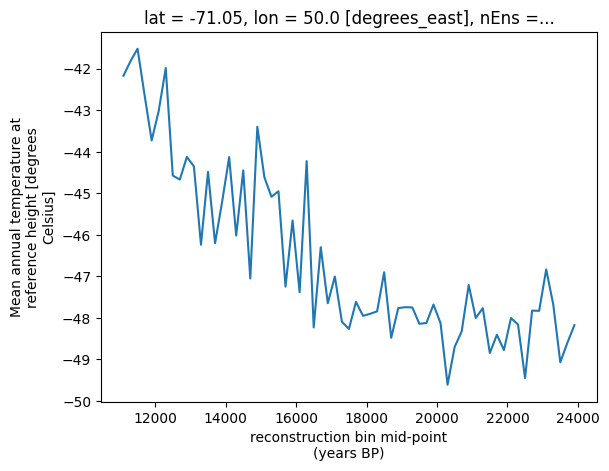

In [35]:
ds_sat['sat'].isel(nEns=0).isel(lat=10).isel(lon=20).plot()

# Doing PCA for ensemble data

In [25]:
import xarray as xr
from sklearn.mixture import GaussianMixture
from toolbox import PCA_functions as pf
from toolbox import GMM_functions_single as gfs


# Initialize dictionaries to store the results
exp_v = {}
eofs = {}
pcs = {}

# Loop through each ensemble member in 'nEns'
for i in range(len(ds_sat['nEns'])):
    # Select the ensemble member
    ds_sat_i = ds_sat.isel(nEns=i)
    # print(ds_sat_i.info)


    # Center the data
    ds_sat_i = pf.center_data(ds_sat_i)

    # Weight the Data
    ds_sat_i = pf.apply_weighting(ds_sat_i)

    # # Plot the Centered and Weighted Data for verification
    # lat_index = 77
    # lon_index = 90
    # pf.plot_sat_variables(ds_sat_i, lat_index, lon_index)

    # Perform PCA, using sklearn
    exp_v[i], eofs[i], pcs[i] = pf.sat_PCA_sklearn(ds_sat_i)


shape of the weight: (96,)
shape of the reshaped sat_centered_weighted: (65, 13824)
shape of the reshaped sat_centered_weighted: (65, 13824)
shape of PCs: (65, 2)
Explained variance: [0.8142782  0.07032195]
shape of EOFs: (13824, 2)
shape of the weight: (96,)
shape of the reshaped sat_centered_weighted: (65, 13824)
shape of the reshaped sat_centered_weighted: (65, 13824)
shape of PCs: (65, 2)
Explained variance: [0.81661916 0.06928881]
shape of EOFs: (13824, 2)
shape of the weight: (96,)
shape of the reshaped sat_centered_weighted: (65, 13824)
shape of the reshaped sat_centered_weighted: (65, 13824)
shape of PCs: (65, 2)
Explained variance: [0.82662624 0.06457878]
shape of EOFs: (13824, 2)
shape of the weight: (96,)
shape of the reshaped sat_centered_weighted: (65, 13824)
shape of the reshaped sat_centered_weighted: (65, 13824)
shape of PCs: (65, 2)
Explained variance: [0.80023116 0.08671817]
shape of EOFs: (13824, 2)
shape of the weight: (96,)
shape of the reshaped sat_centered_weight

# Save the exp_v, eofs, and pcs 

In [26]:
# store the exp_v, eofs, and pcs to path /ens_ana_data/
import pickle
pickle.dump(exp_v, open('ens_ana_data/exp_v.p', 'wb'))
pickle.dump(eofs, open('ens_ana_data/eofs.p', 'wb'))
pickle.dump(pcs, open('ens_ana_data/pcs.p', 'wb'))


In [3]:
# Load the exp_v, eofs, and pcs from path /ens_ana_data/
import pickle
exp_v = pickle.load(open('ens_ana_data/exp_v.p', 'rb'))
eofs = pickle.load(open('ens_ana_data/eofs.p', 'rb'))
pcs = pickle.load(open('ens_ana_data/pcs.p', 'rb'))

# Calculate the AIC and Determine the optimal number of classes

In [28]:
import xarray as xr
from sklearn.mixture import GaussianMixture
from toolbox import PCA_functions as pf

n_components_range = range(2, 9)  # 2 to 8 inclusive

aic_values_dict = {}

# Loop over the range of components
for n_components in n_components_range:
    aic_values = []

    for i in range(len(ds_sat['nEns'])):

        # create a 2D GMM model
        gmm = GaussianMixture(n_components=n_components, covariance_type='full')

        gmm.fit(eofs[i])

        aic_values.append(gmm.aic(eofs[i]))
    
    # Record the AIC values for this number of components
    aic_values_dict[n_components] = aic_values

# Save the AIC

In [29]:
# save the aic_values_dict
import pickle
with open('ens_ana_data/aic_values_dict.pkl', 'wb') as f:
    pickle.dump(aic_values_dict, f)

In [8]:
# read the aic_values_dict
import pickle
with open('ens_ana_data/aic_values_dict.pkl', 'rb') as f:
    aic_values_dict = pickle.load(f)

# Plot AIC and delta AIC

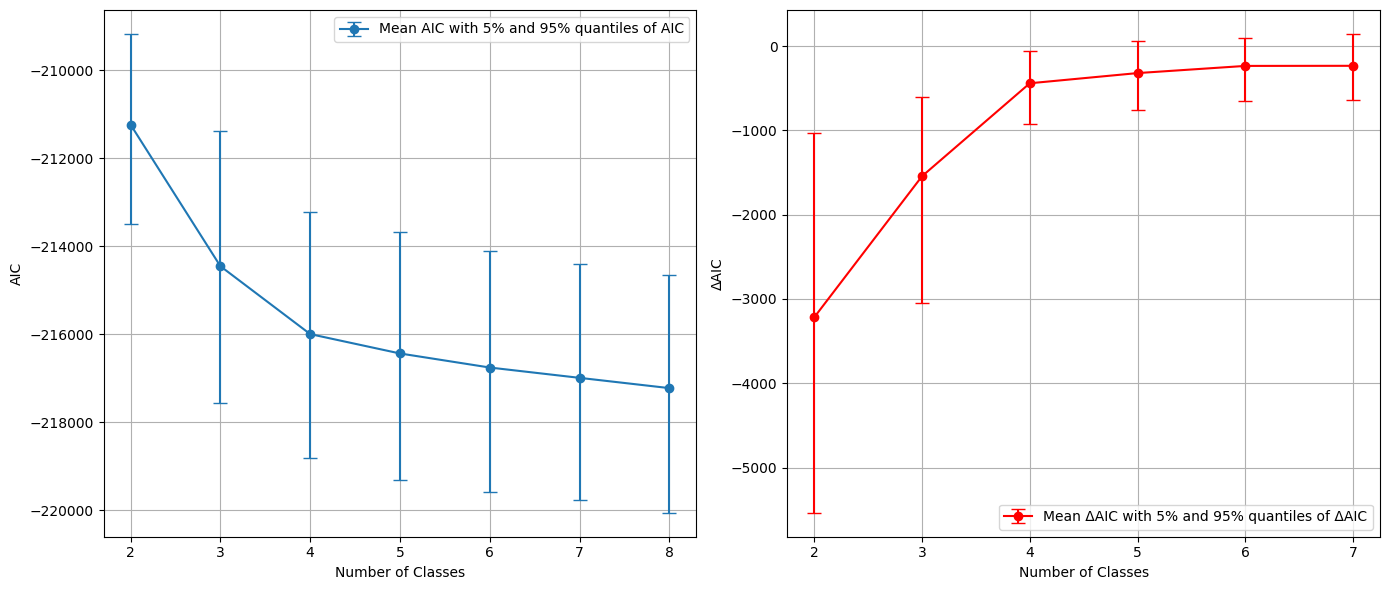

In [10]:
import numpy as np
from matplotlib import pyplot as plt

n_iterations = len(ds_sat['nEns'])

n_components_range = range(2, 9)  # 2 to 8 inclusive

# Compute means, lower and upper limits
means = [np.mean(aic_values_dict[key]) for key in n_components_range]
lower_limits = [np.percentile(aic_values_dict[key], 5) for key in n_components_range]
upper_limits = [np.percentile(aic_values_dict[key], 95) for key in n_components_range]

# Differences from the mean for error bars
lower_errors = [mean - lower for mean, lower in zip(means, lower_limits)]
upper_errors = [upper - mean for mean, upper in zip(means, upper_limits)]

# Compute ΔAIC for each n_components during each Monte Carlo iteration
delta_aics_all_iterations = []
for i in range(n_iterations):
    iteration_delta_aics = np.diff([aic_values_dict[n][i] for n in n_components_range])
    delta_aics_all_iterations.append(iteration_delta_aics)

# Convert to a 2D numpy array for easier operations
delta_aics_all_iterations = np.array(delta_aics_all_iterations)

# Now, compute the mean ΔAIC and its 5% and 95% quantiles
delta_aics_means = np.mean(delta_aics_all_iterations, axis=0)
delta_aics_lowers = np.percentile(delta_aics_all_iterations, 5, axis=0)
delta_aics_uppers = np.percentile(delta_aics_all_iterations, 95, axis=0)

# Differences from the mean ΔAIC for error bars
delta_lower_errors = delta_aics_means - delta_aics_lowers
delta_upper_errors = delta_aics_uppers - delta_aics_means

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# AIC Plot
ax[0].errorbar(n_components_range, means, yerr=[lower_errors, upper_errors], 
               capsize=5, fmt='-o', label='Mean AIC with 5% and 95% quantiles of AIC')
ax[0].set_xlabel('Number of Classes')
ax[0].set_ylabel('AIC')
ax[0].legend()
ax[0].grid(True)

# ΔAIC Plot
ax[1].errorbar(n_components_range[:-1], delta_aics_means, yerr=[delta_lower_errors, delta_upper_errors], 
               capsize=5, fmt='-o', color='red', label='Mean ΔAIC with 5% and 95% quantiles of ΔAIC')
ax[1].set_xlabel('Number of Classes')
ax[1].set_ylabel('ΔAIC')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

# Doing PCA and GMM for each sat dataset in the ensembles

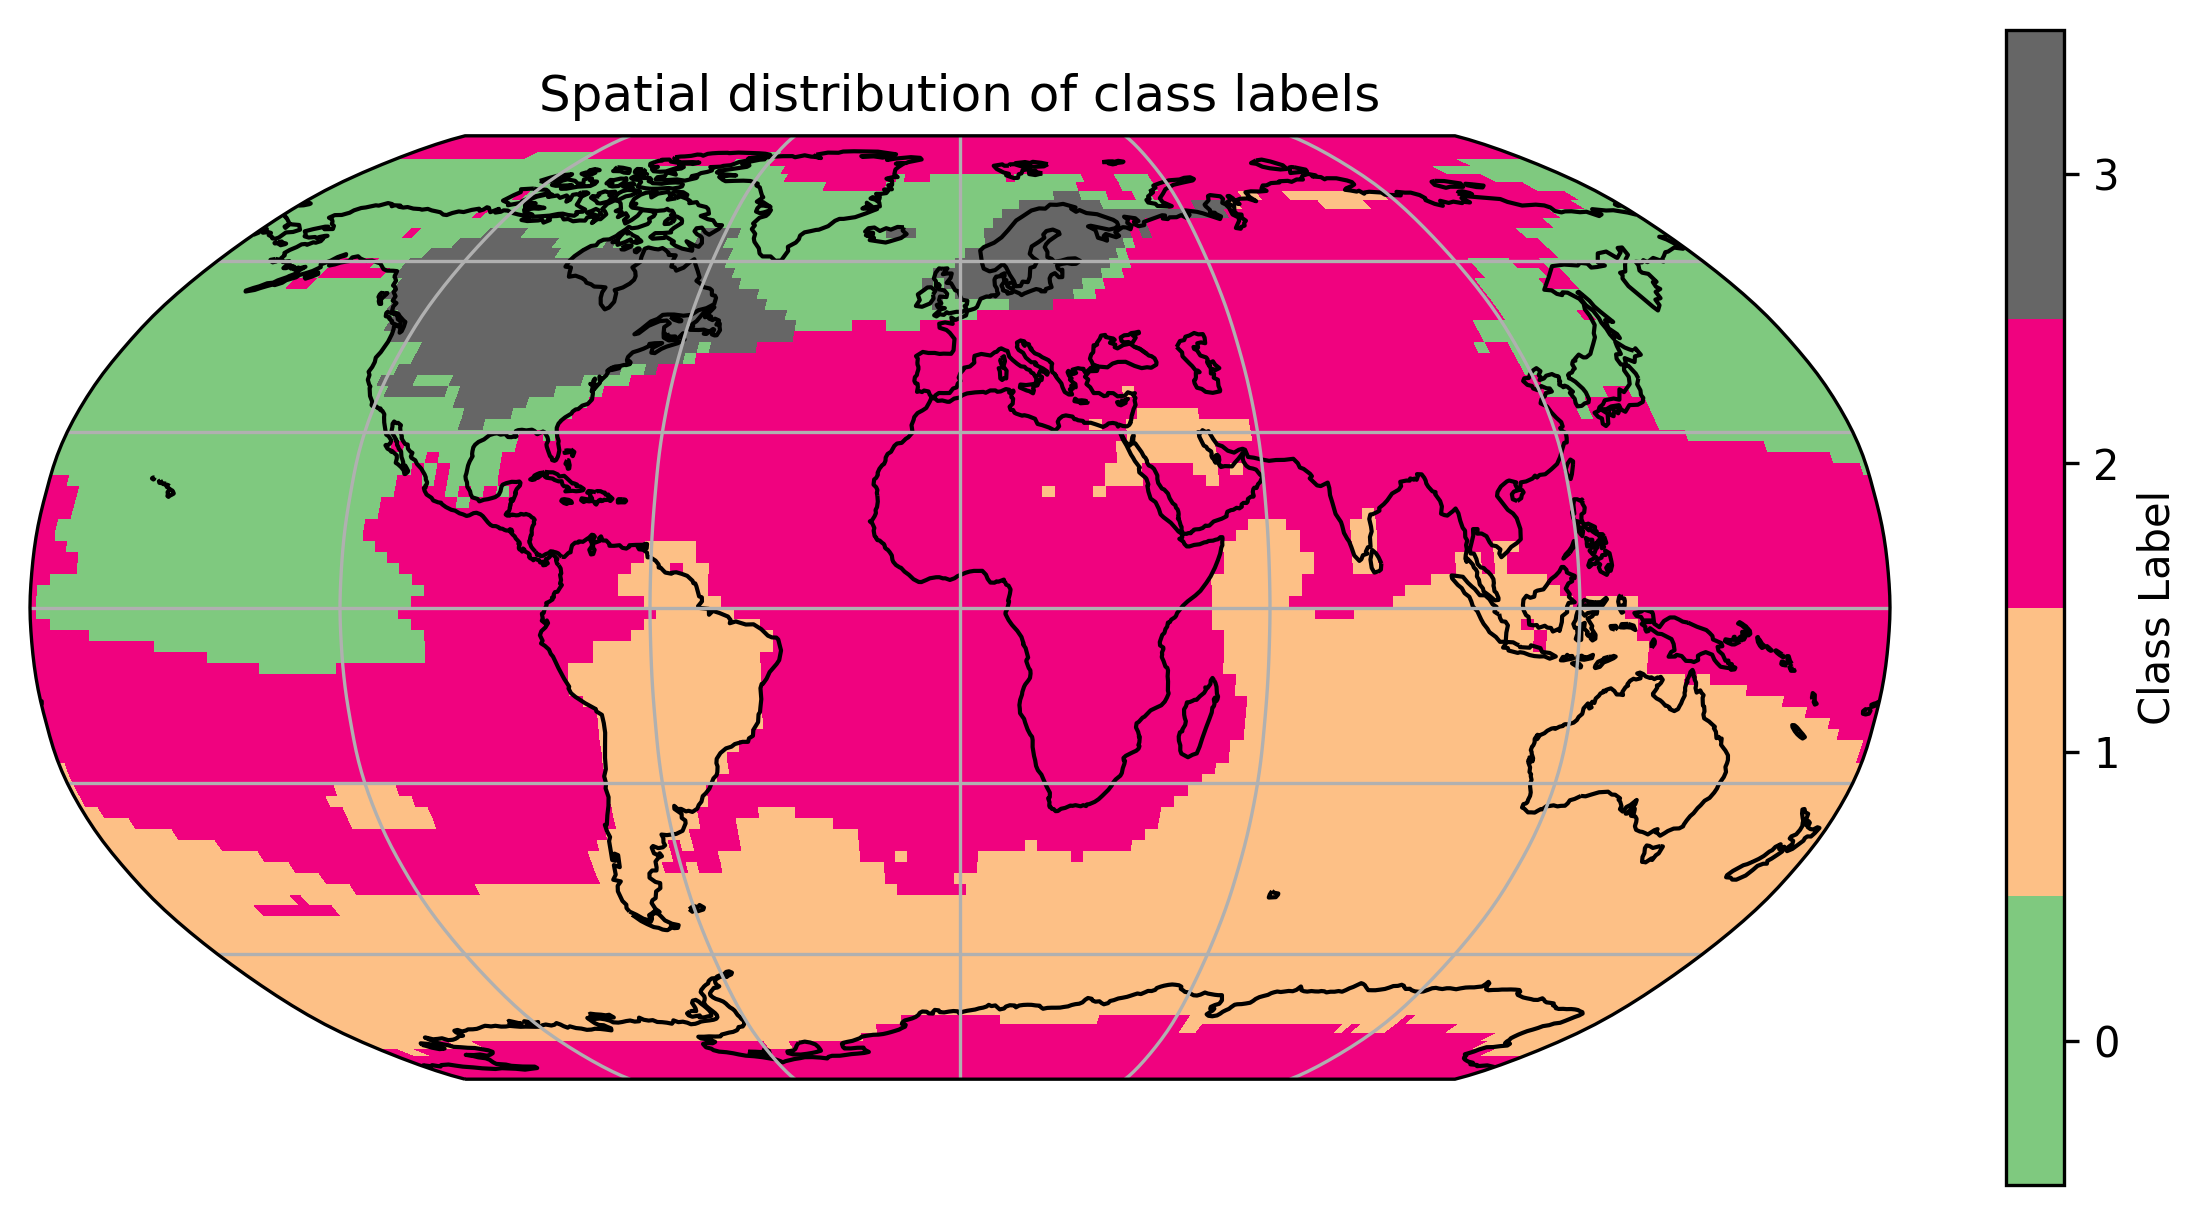

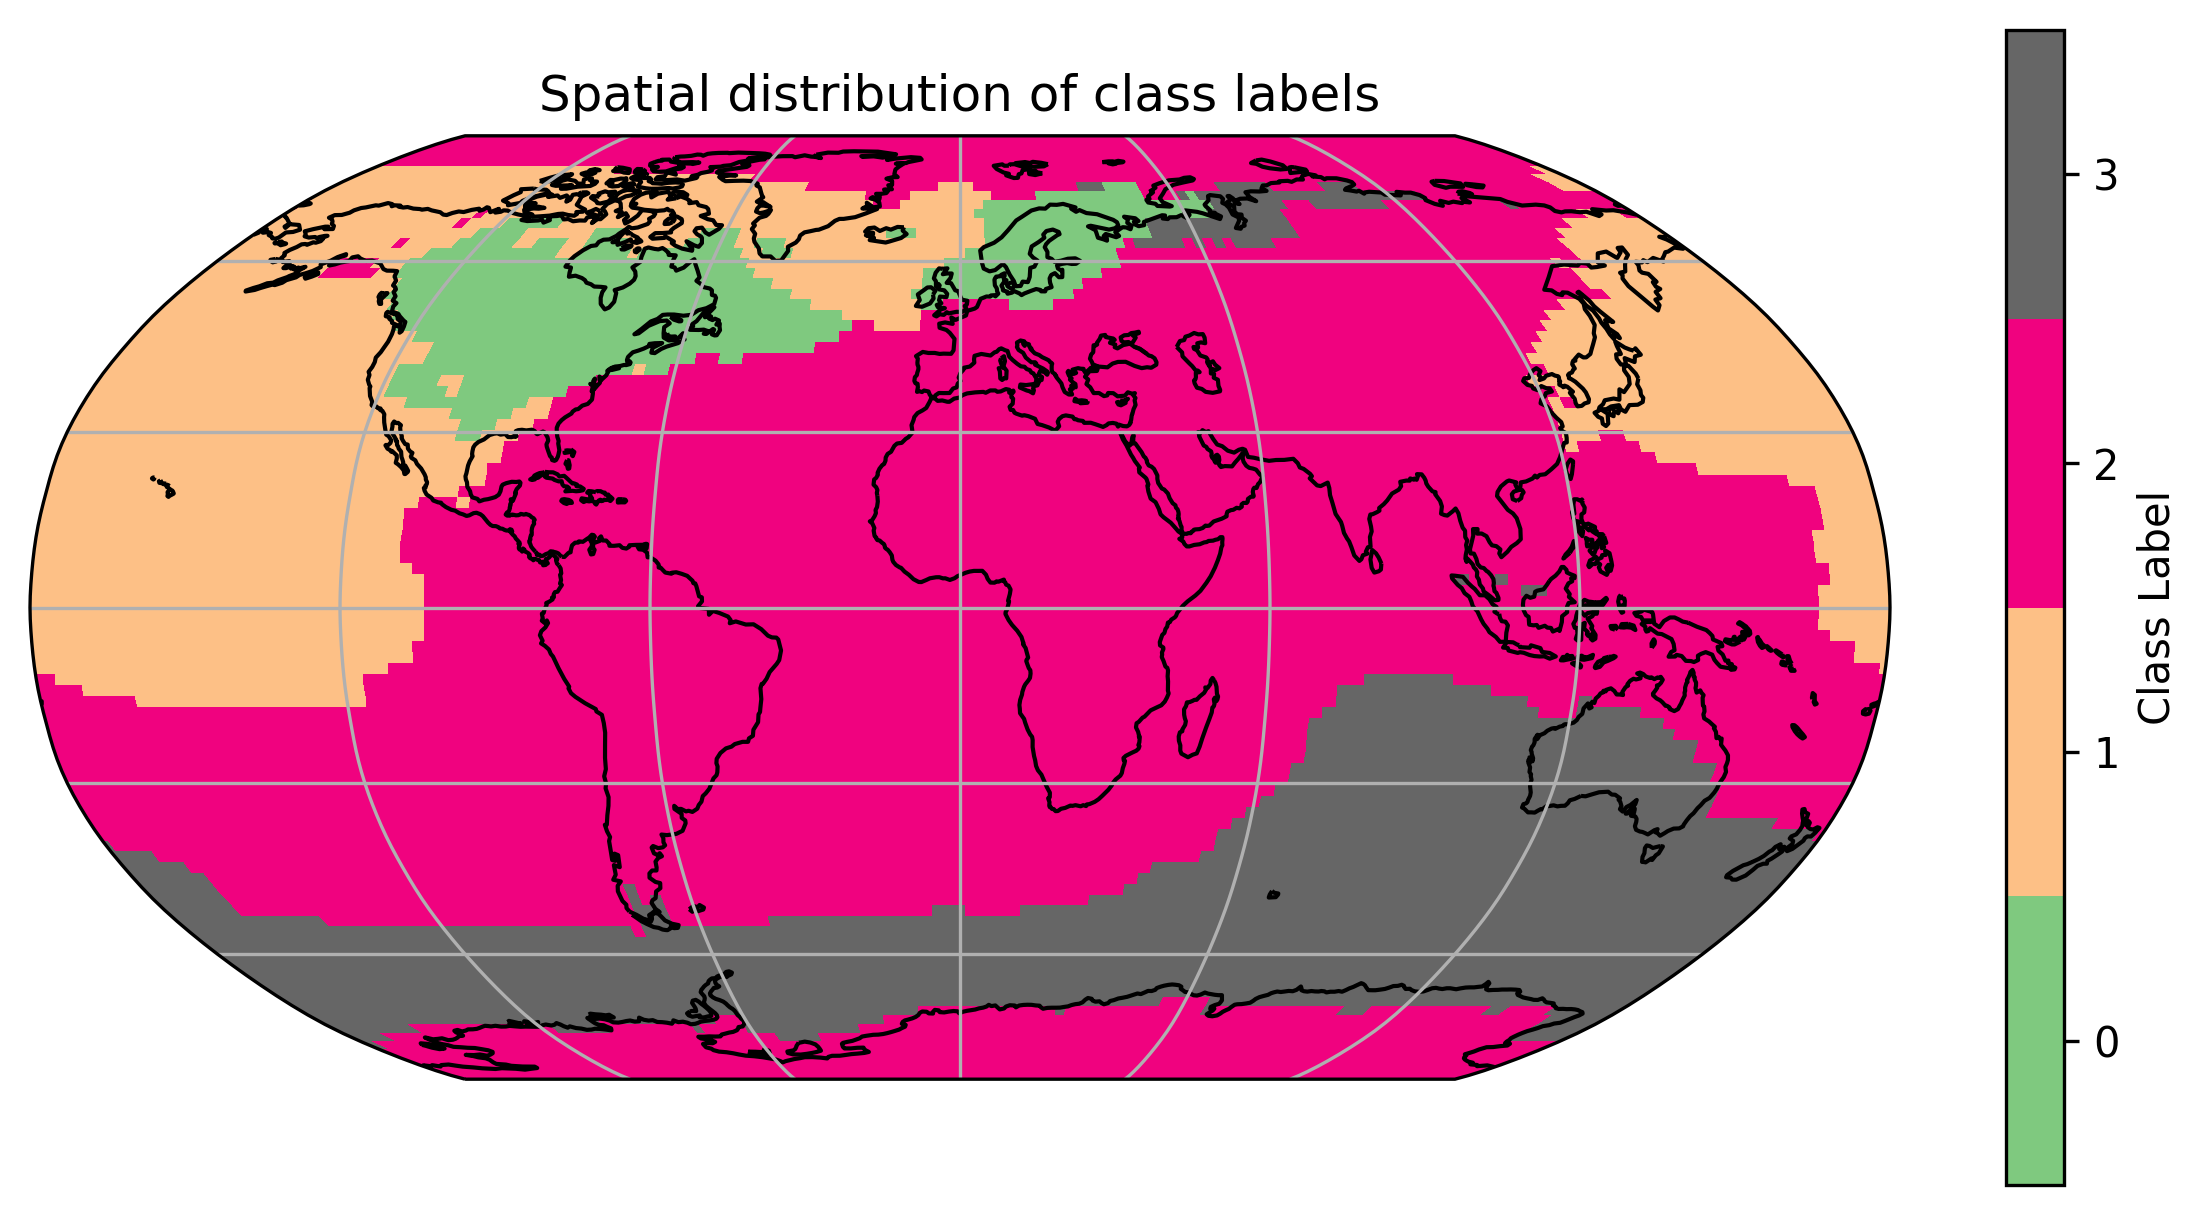

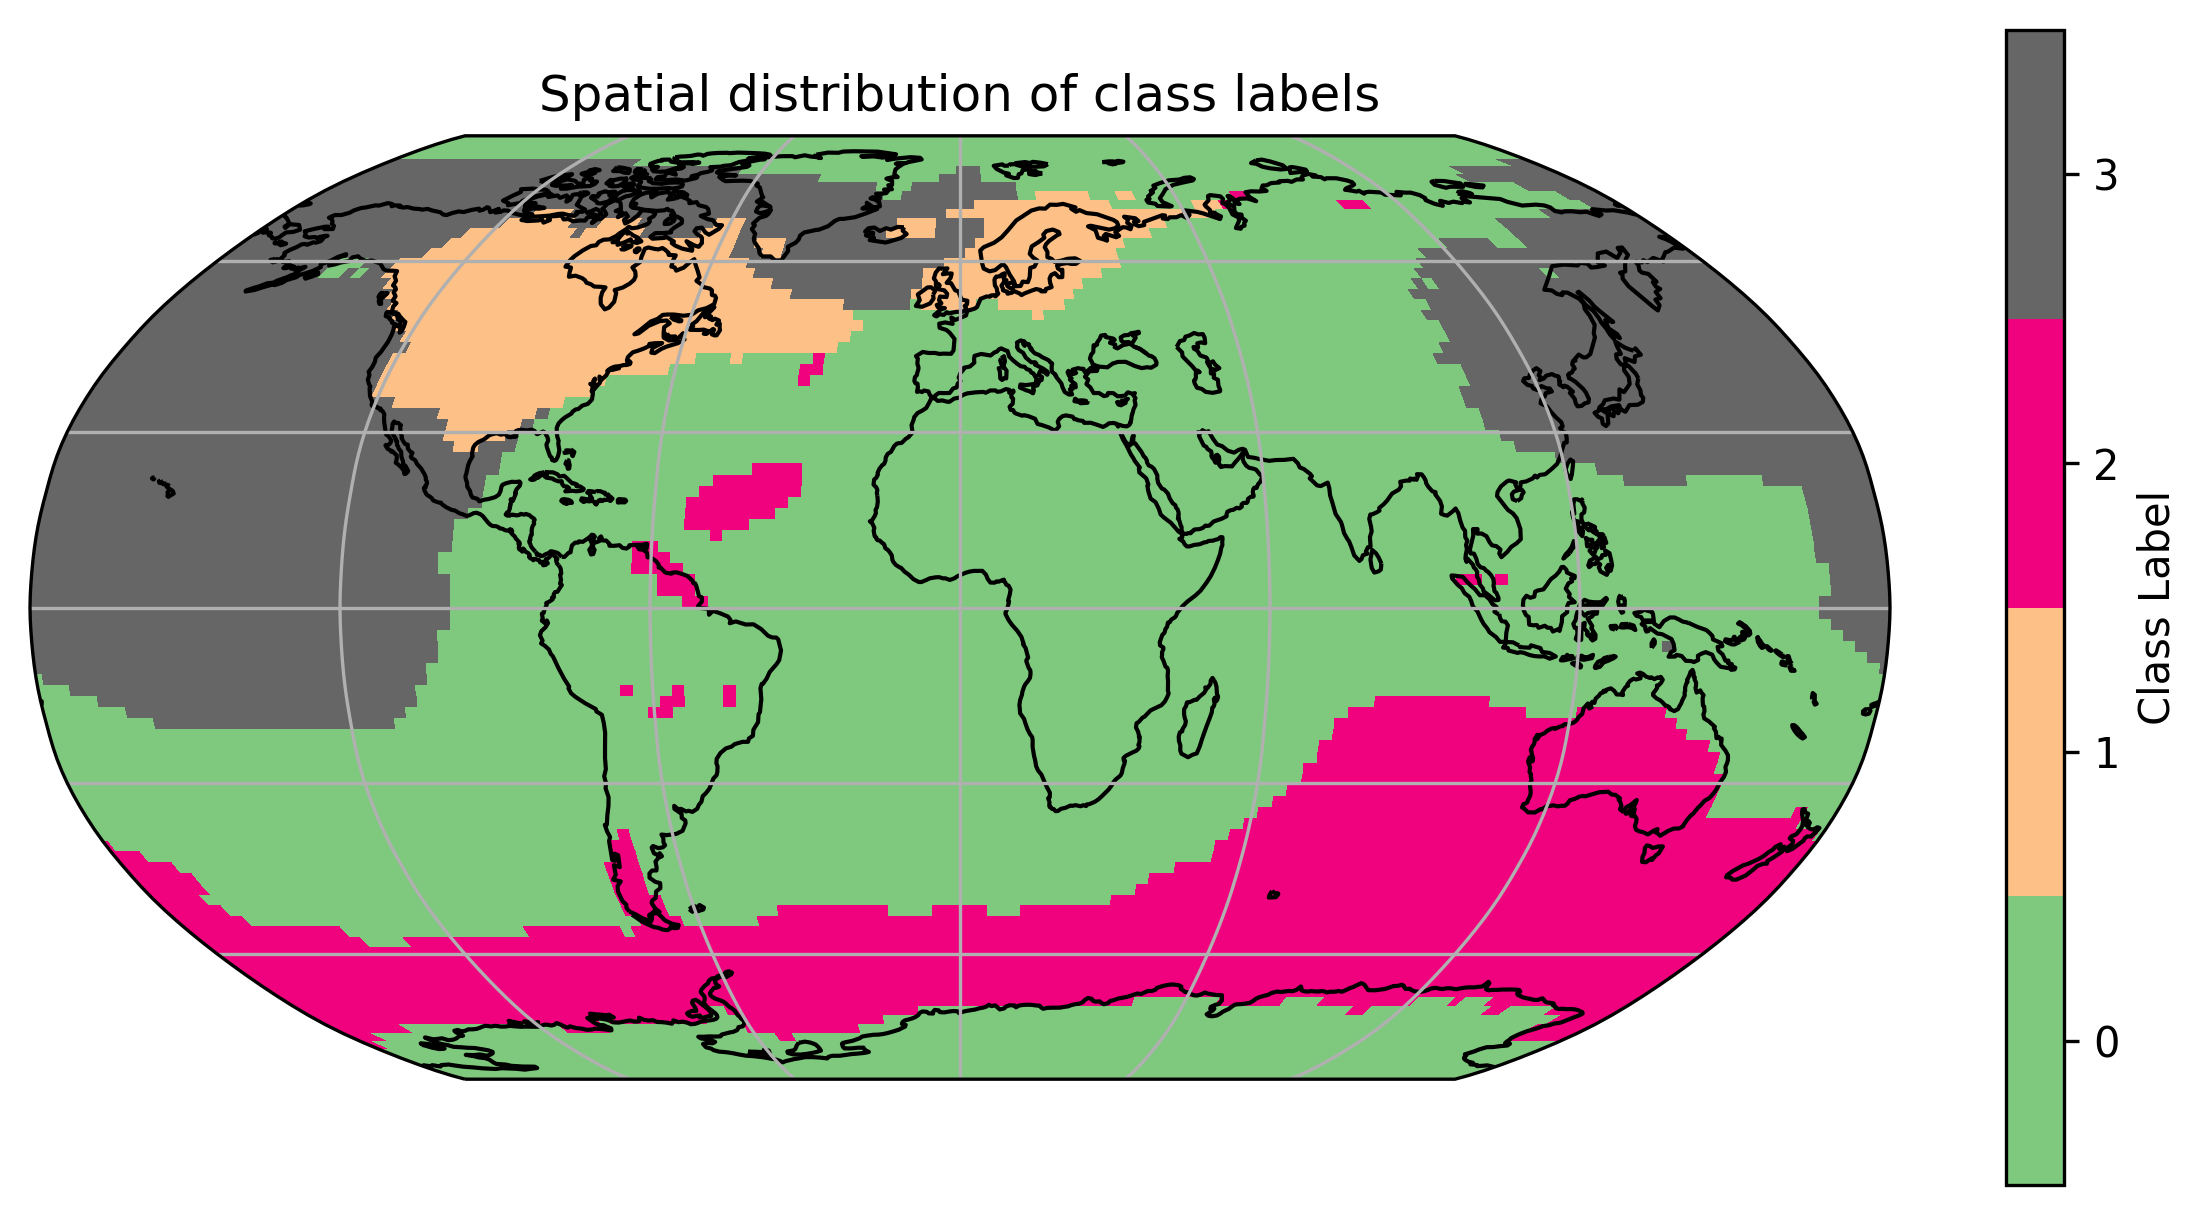

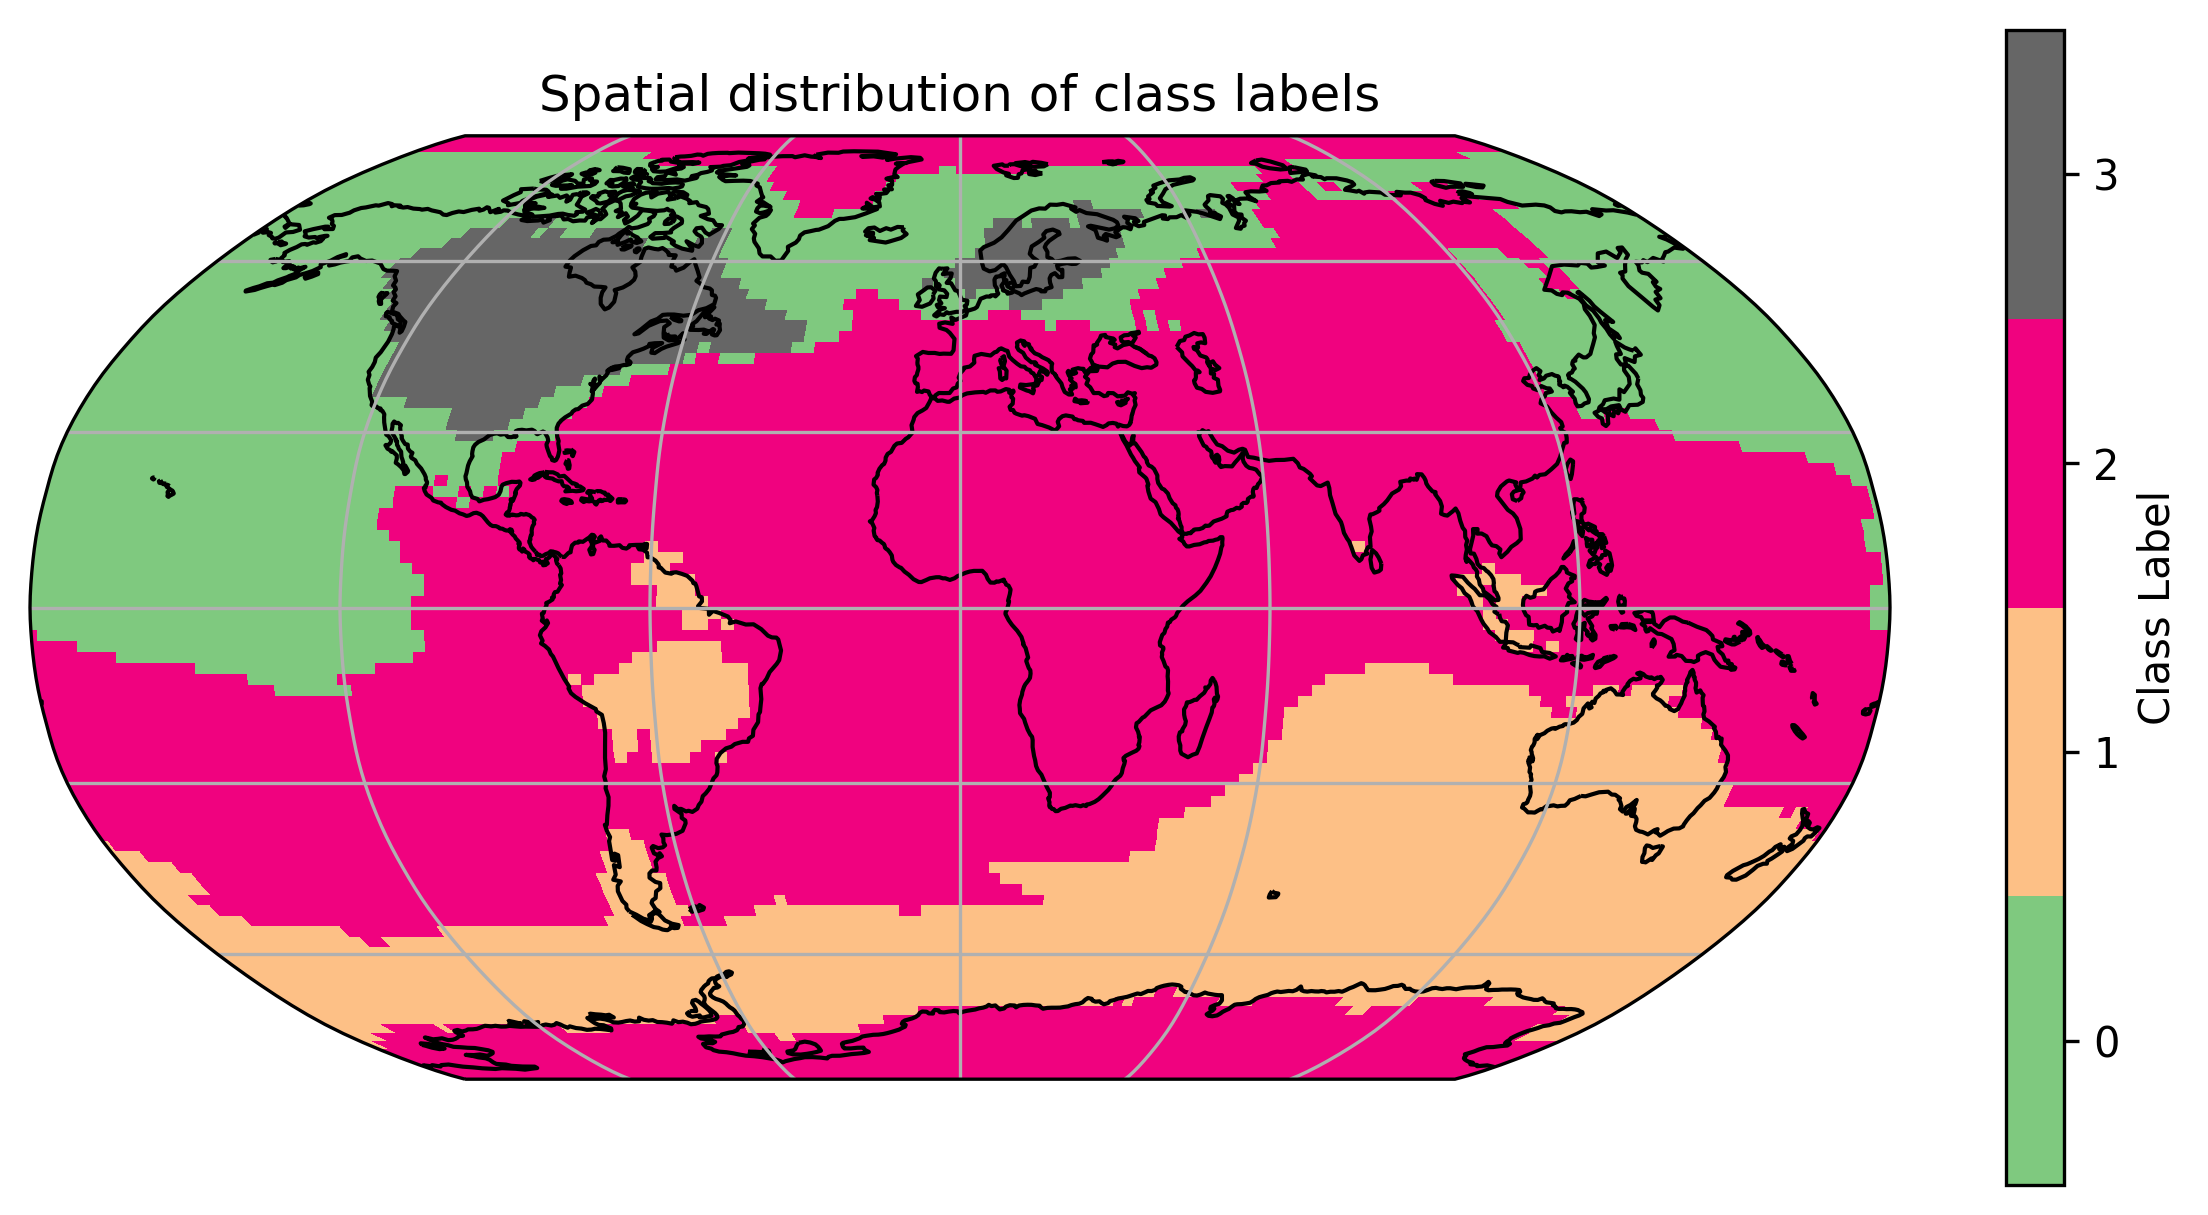

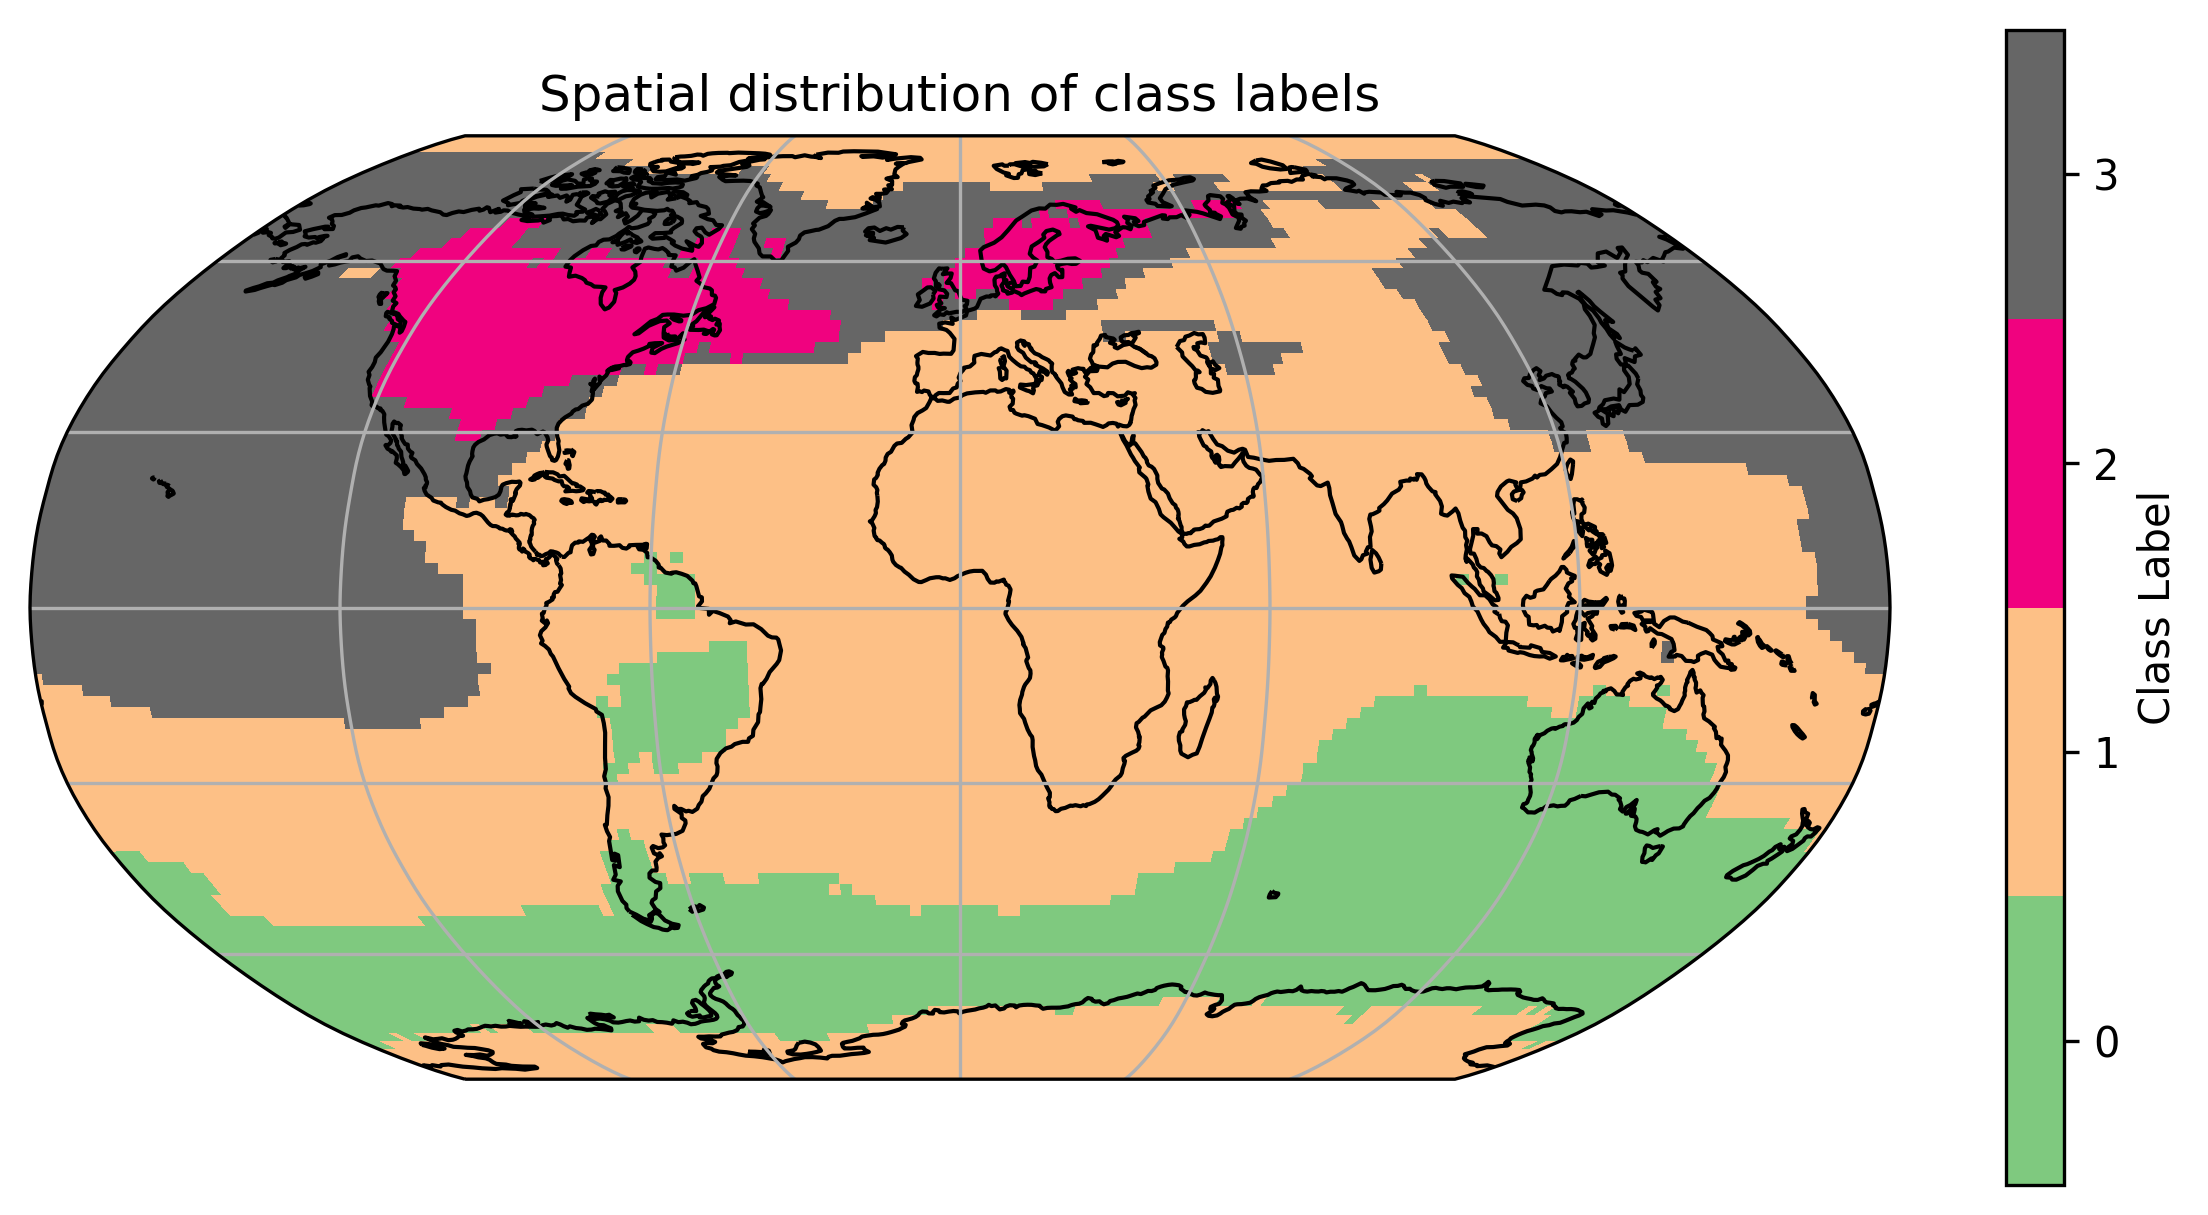

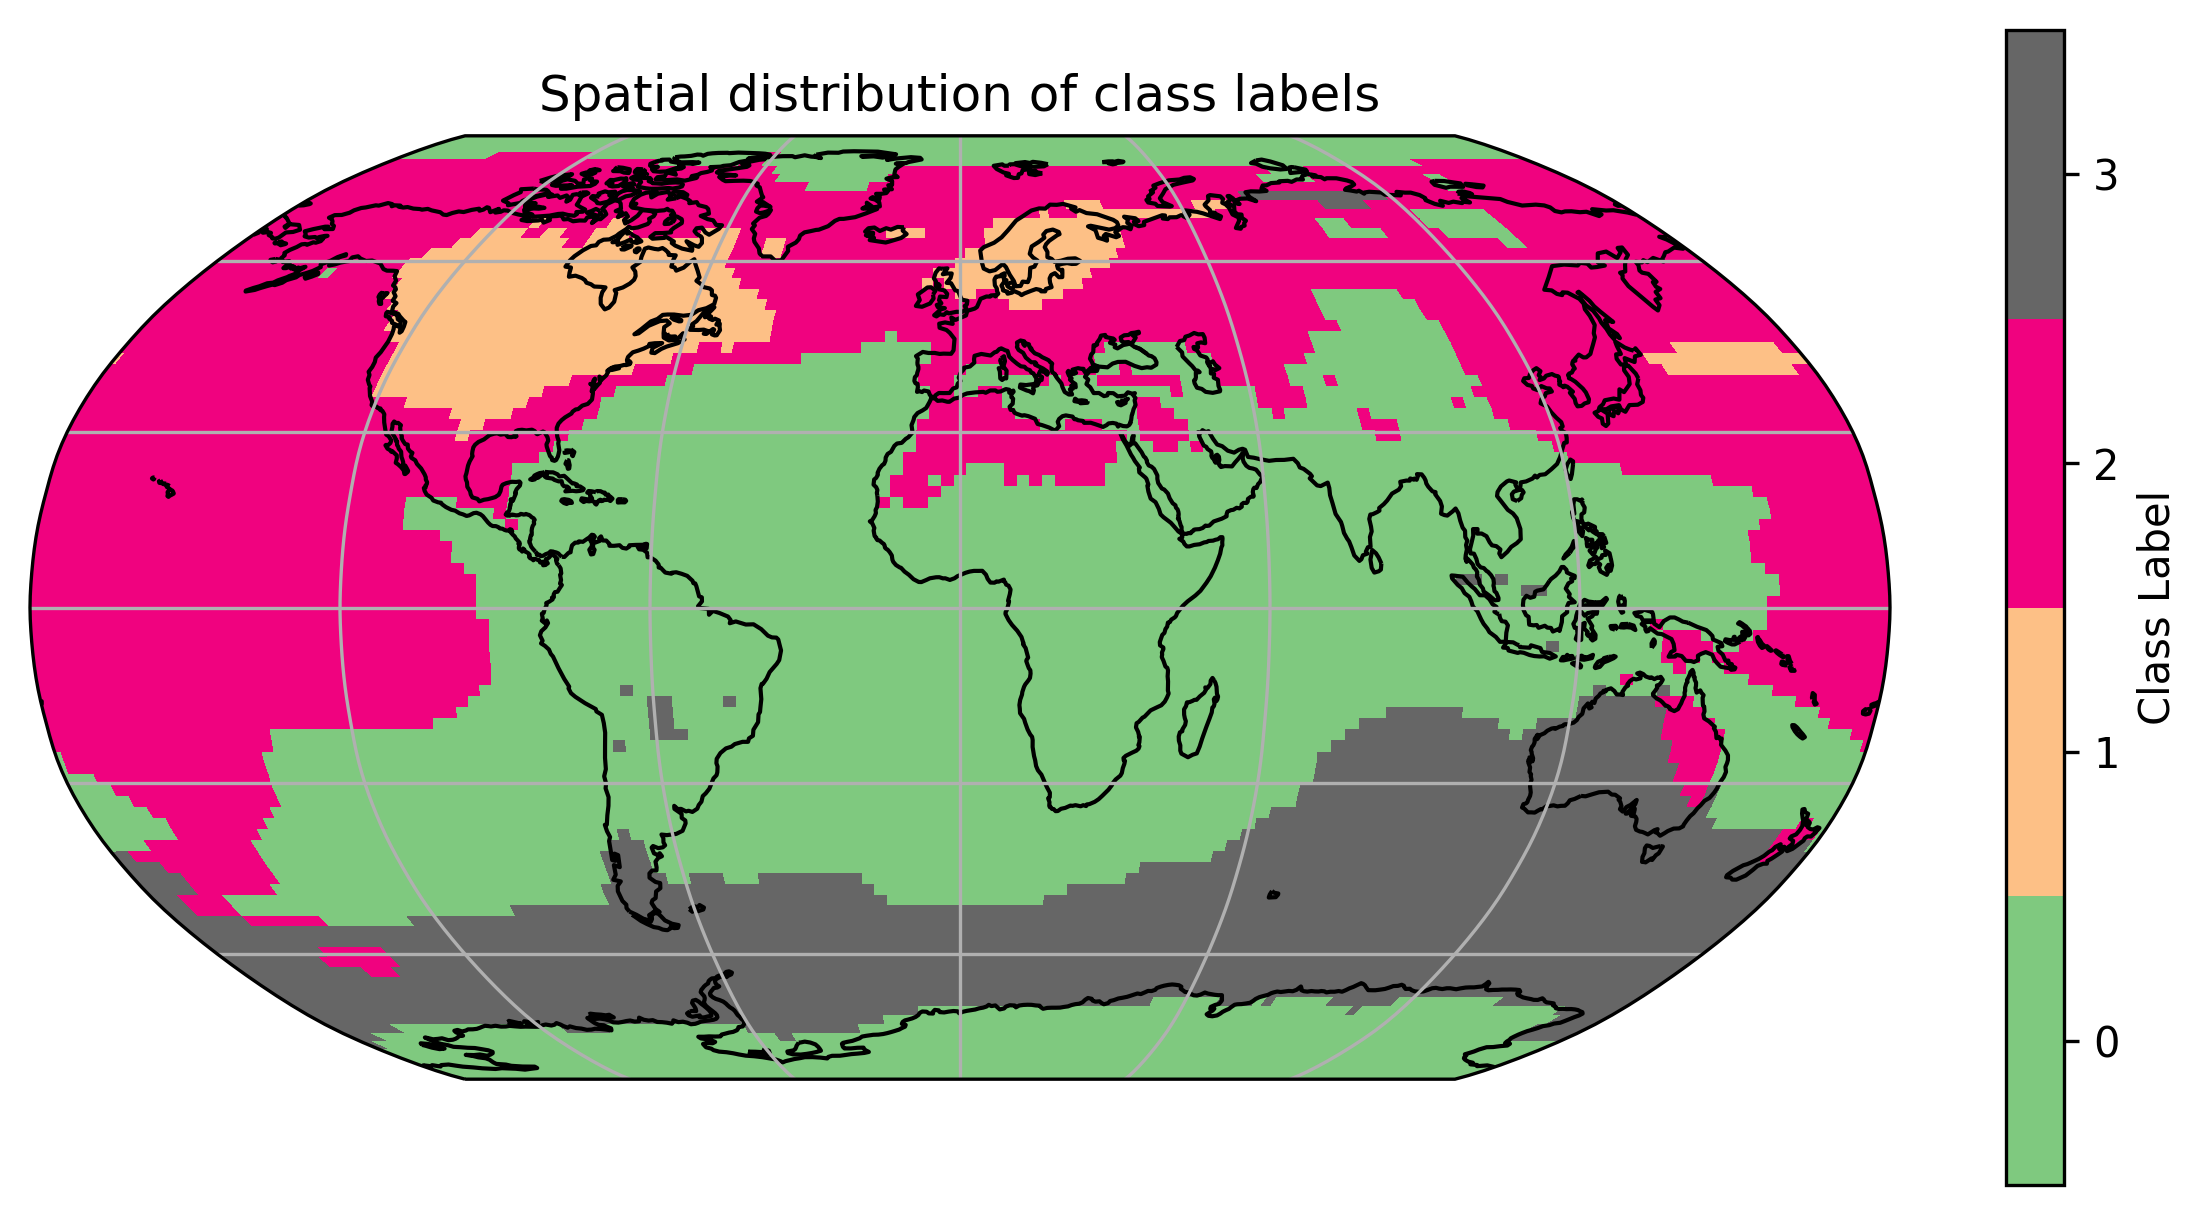

In [4]:
import xarray as xr
from sklearn.mixture import GaussianMixture
from toolbox import PCA_functions as pf
from toolbox import GMM_functions_single as gfs


labels_Ens = []

n_components=4


# Loop through each ensemble member in 'nEns'
for i in range(len(ds_sat['nEns'])):

    # create a 2D GMM model
    gmm_model = GaussianMixture(n_components=n_components, covariance_type='full')

    # fit the model to the two columns of PCA scores
    gmm_model.fit(eofs[i])

    # get the predicted class labels for each data point
    labels = gmm_model.predict(eofs[i])

    # Store results for each iteration
    labels_Ens.append({
        'labels': labels,
    })

    if i<=5:
        # Select the ensemble member
        ds_sat_i = ds_sat.isel(nEns=i)
        ds_sat_i['class_label'] = (('lat', 'lon'), labels.reshape(ds_sat_i['sat'].shape[1], ds_sat_i['sat'].shape[2]))
        gfs.plot_labels(ds_sat_i)

    # if i==10:
    #     break



# Save the labels

In [5]:
# save the labels_Ens
import pickle
with open('ens_ana_data/labels_Ens.pkl', 'wb') as f:
    pickle.dump(labels_Ens, f)

In [3]:
# read the labels_Ens
import pickle
with open('ens_ana_data/labels_Ens.pkl', 'rb') as f:
    labels_Ens = pickle.load(f)

# Plot the uncorrected labels

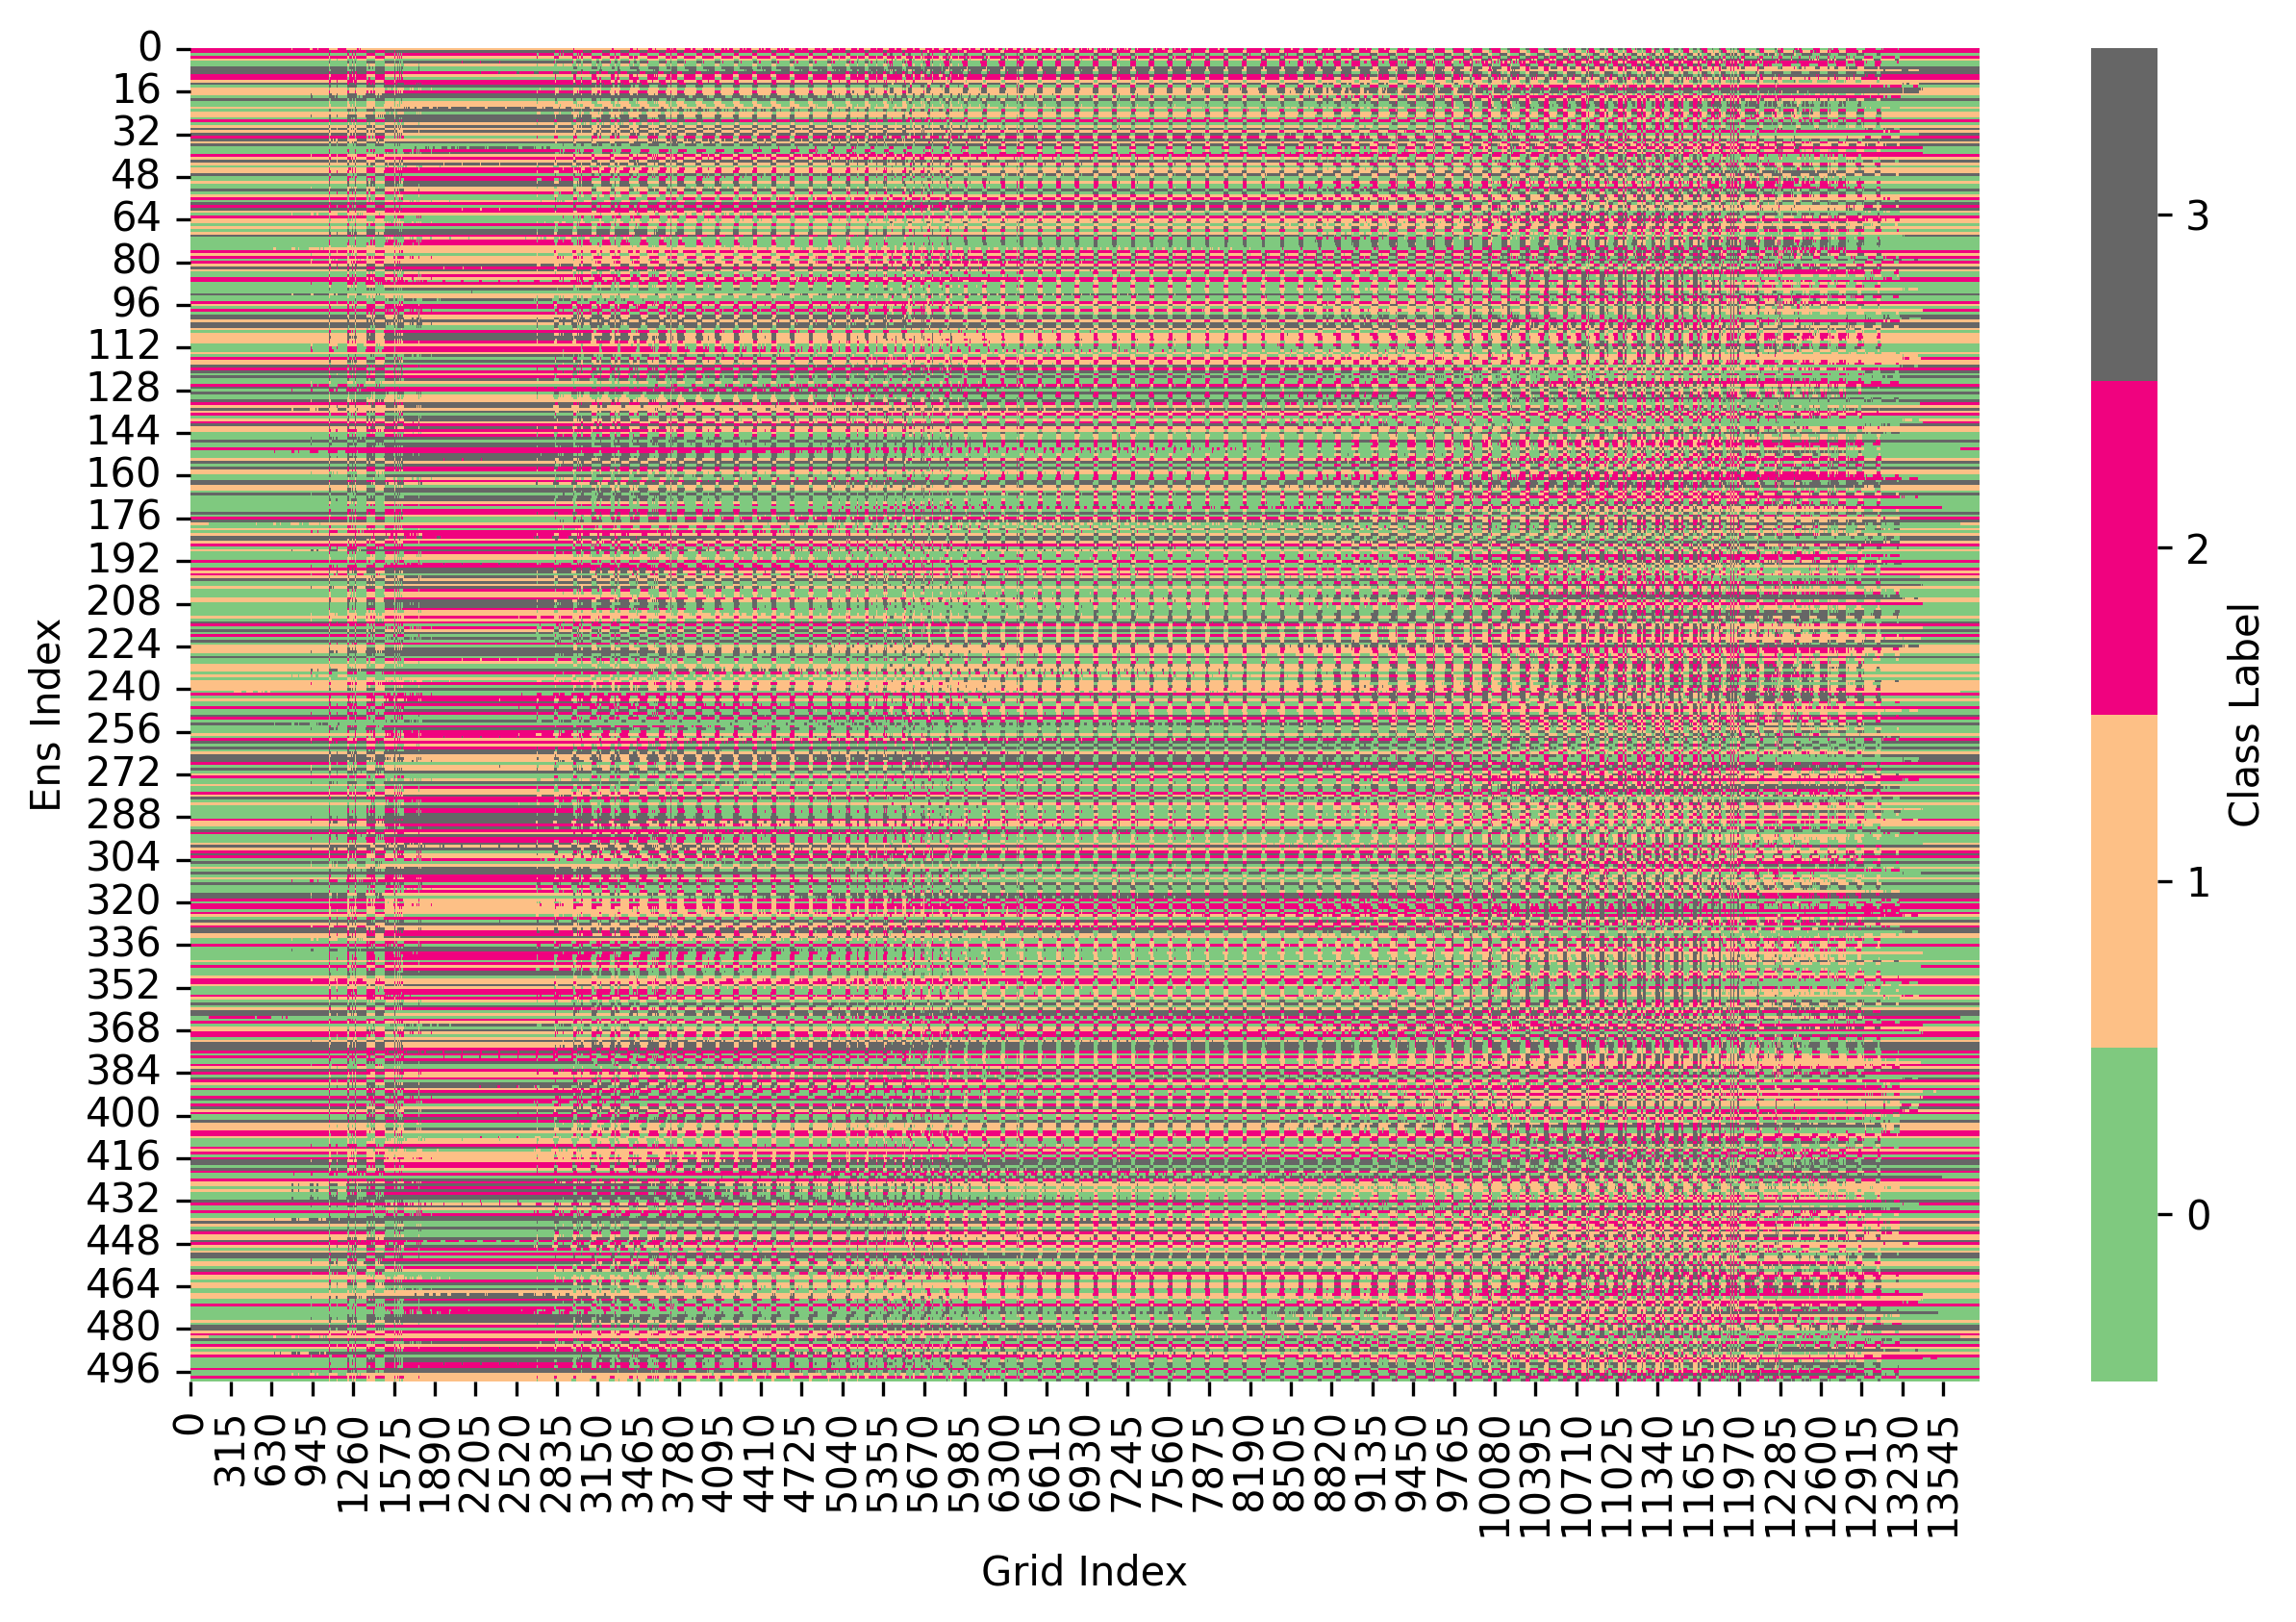

In [2]:
from toolbox import Ens_ana_functions as eaf
eaf.plot_ens_labels(labels_Ens)

# Load the reference labels

In [4]:
# load the ds_GMM_climo_relabeled
import xarray as xr
ds_GMM_climo_relabeled = xr.open_dataset('climo_ana_data/ds_GMM_climo_relabeled.nc')
# ds_GMM_climo_relabeled
ref_labels = ds_GMM_climo_relabeled['class_relabeled'].values.reshape(96*144,)

# Correct labels

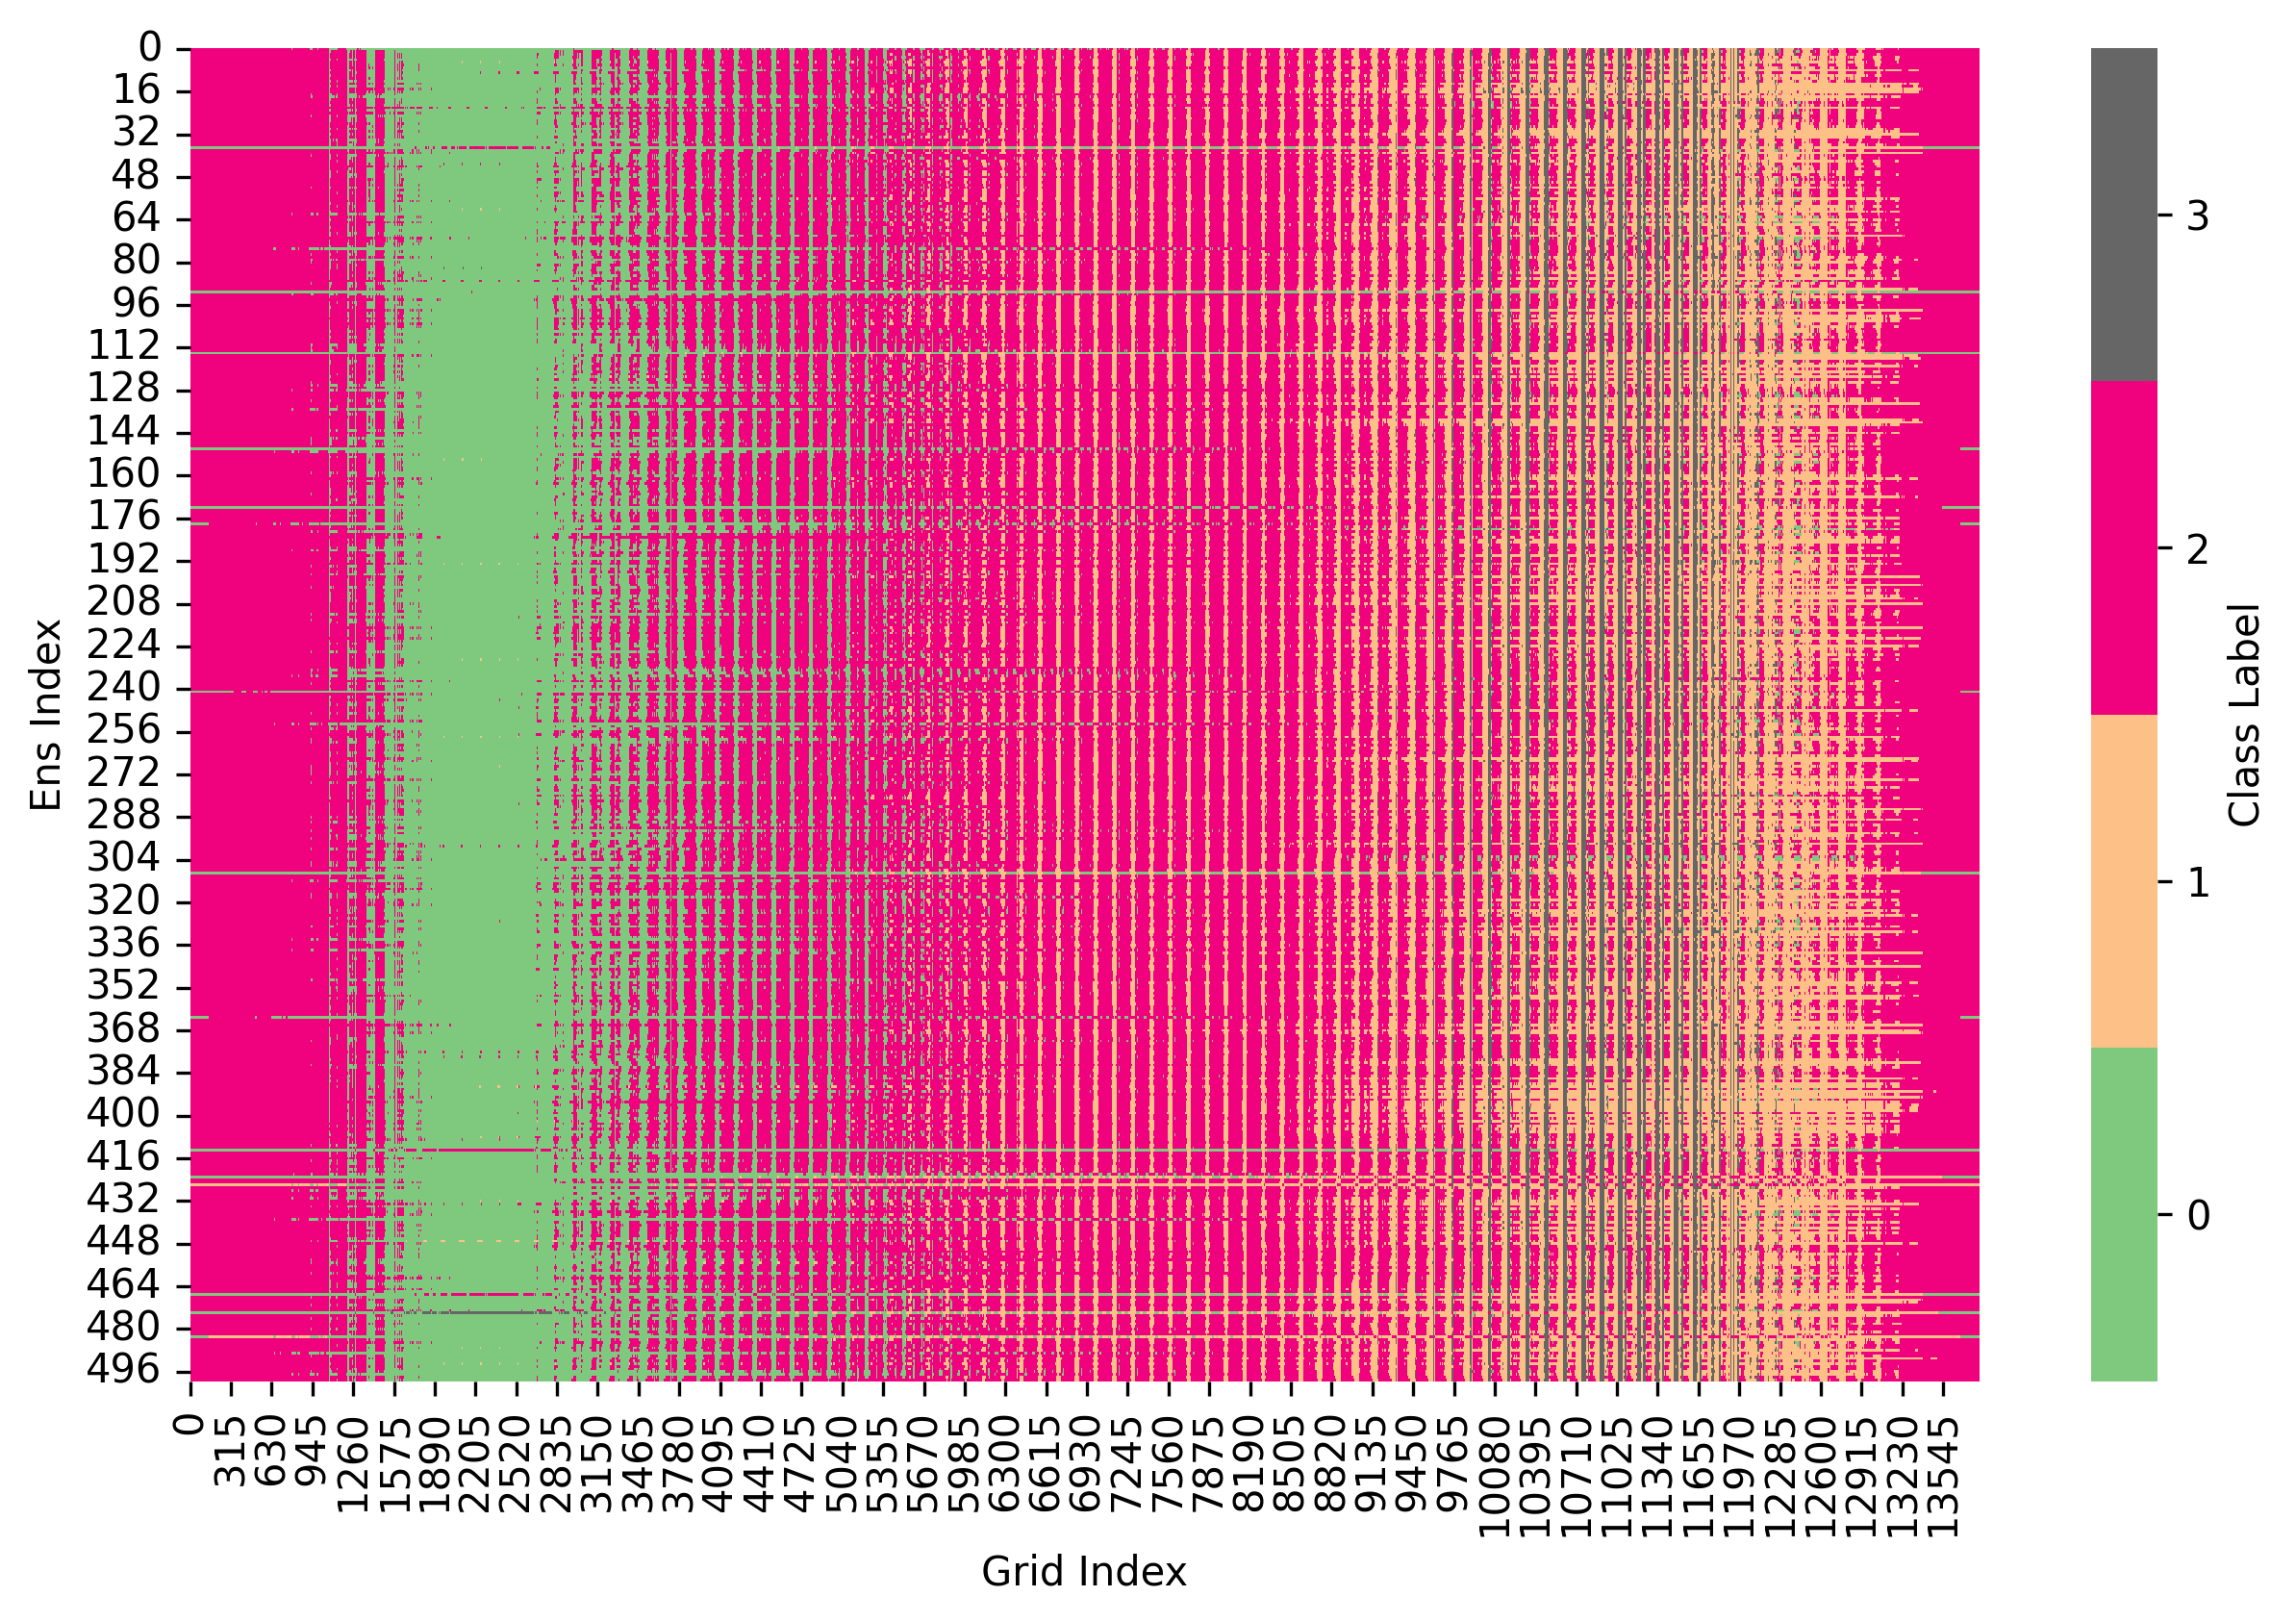

In [5]:
from toolbox import Ens_ana_functions as eaf
labels_Ens_aligned=eaf.align_labels(labels_Ens,reference_labels=ref_labels)
eaf.plot_ens_labels(labels_Ens_aligned)

In [6]:
# save the labels_Ens_aligned
import pickle
with open('ens_ana_data/labels_Ens_aligned.pkl', 'wb') as f:
    pickle.dump(labels_Ens_aligned, f)

In [3]:
# read the labels_Ens_aligned
import pickle

with open('ens_ana_data/labels_Ens_aligned.pkl', 'rb') as f:
    labels_Ens_aligned = pickle.load(f)

In [5]:
# import numpy as np
# from toolbox import change_point_functions as cpf

# sat_shape = ds_sat['sat'].isel(nEns=0).shape

# # Initialize a list to store cp_i for all iterations
# all_cp = []

# for i in range(len(ds_sat['nEns'])):
#     # Select the ensemble member
#     ds_sat_i = ds_sat.isel(nEns=i)
    
#     ds_sat_i['class_label'] = (('lat', 'lon'), labels_Ens_aligned[i]['labels'].reshape(sat_shape[1], sat_shape[2]))
#     weighted_avg_curves = {}

#     # Initialize cp_i for this iteration
#     cp_i = []
    
#     for j in range(len(np.unique(labels_Ens_aligned[i]['labels']))):
#         weighted_avg_curves[j] = cpf.cal_weighted_average_curve(ds_sat_i, j)
        
#         min_index = np.argmin(weighted_avg_curves[j])
#         cp_i.append(ds_sat['age'].values[min_index])

#         # cp_climo_info = cpf.find_cp(weighted_avg_curves[j], ds_sat['age'].values, avg_plot=False)
#         # # Append the cp_age for the current k to cp_i
#         # cp_i.append(cp_climo_info['cp_age'])


    
#     # Append cp_i of the current iteration to the list of all cp_i
#     all_cp.append(cp_i)

# # Convert all_cp_i to a NumPy array
# all_cp_array_M_min = np.array(all_cp)


In [10]:
import numpy as np
from toolbox import change_point_functions as cpf

sat_shape = ds_sat['sat'].isel(nEns=0).shape

# Initialize a list to store cp_i for all iterations
all_cp = []

# Initialize a list to store the weighted average curves for all iterations
all_weighted_avg_curves = []

for i in range(len(ds_sat['nEns'])):
    # Select the ensemble member
    ds_sat_i = ds_sat.isel(nEns=i)
    
    ds_sat_i['class_label'] = (('lat', 'lon'), labels_Ens_aligned[i]['labels'].reshape(sat_shape[1], sat_shape[2]))
    weighted_avg_curves = {}

    # Initialize cp_i for this iteration
    cp_i = []
    
    for j in range(len(np.unique(labels_Ens_aligned[i]['labels']))):
        weighted_avg_curves[j] = cpf.cal_weighted_average_curve(ds_sat_i, j)
        
        min_index = np.argmin(weighted_avg_curves[j])
        cp_i.append(ds_sat['age'].values[min_index])

        # cp_climo_info = cpf.find_cp(weighted_avg_curves[j], ds_sat['age'].values, avg_plot=False)
        # # Append the cp_age for the current k to cp_i
        # cp_i.append(cp_climo_info['cp_age'])

    # Append the dictionary of weighted average curves for the current iteration to the list
    all_weighted_avg_curves.append(weighted_avg_curves)
    
    # Append cp_i of the current iteration to the list of all cp_i
    all_cp.append(cp_i)

# Convert all_cp_i to a NumPy array
all_cp_array_M_min = np.array(all_cp)

# Store the average curves

In [14]:
# save the all_weighted_avg_curves
import pickle
with open('ens_ana_data/all_weighted_avg_curves.pkl', 'wb') as f:
    pickle.dump(all_weighted_avg_curves, f)

In [15]:
# read the all_weighted_avg_curves
import pickle
with open('ens_ana_data/all_weighted_avg_curves.pkl', 'rb') as f:
    all_weighted_avg_curves = pickle.load(f)

# Store the change points

In [7]:
# save the all_cp_array_M_min
import pickle
with open('ens_ana_data/all_cp_array_M_min.pkl', 'wb') as f:
    pickle.dump(all_cp_array_M_min, f)

In [8]:
# read the all_cp_array_M_min
import pickle
with open('ens_ana_data/all_cp_array_M_min.pkl', 'rb') as f:
    all_cp_array_M_min = pickle.load(f)

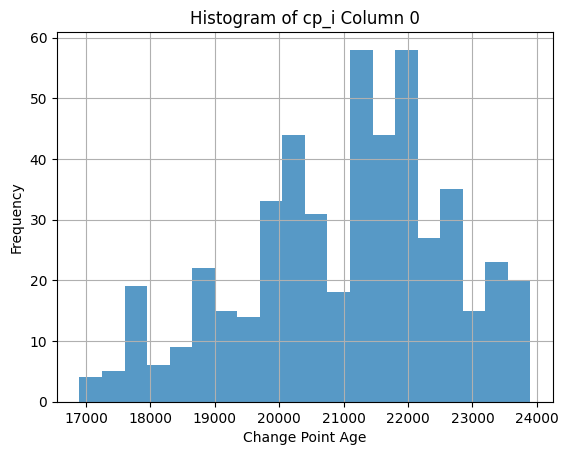

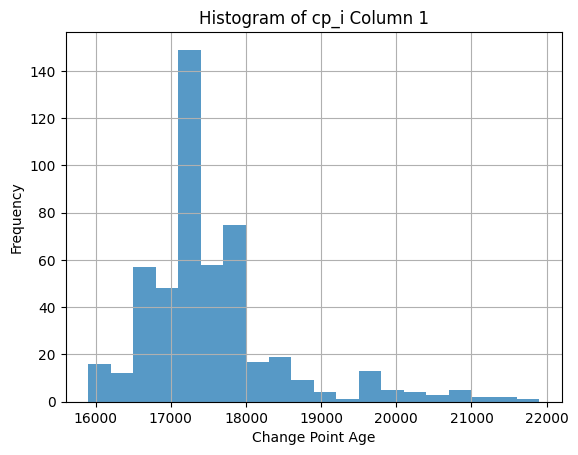

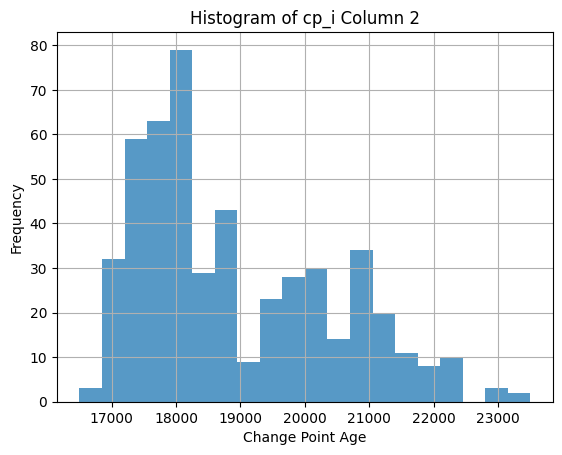

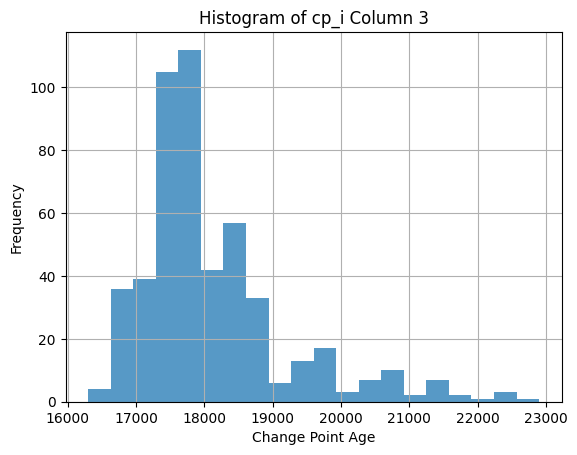

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Plot histograms of the columns of all_cp_i_array
num_columns = all_cp_array_M_min.shape[1]
for idx in range(num_columns):
    plt.figure()  # Create a new figure for each histogram
    plt.hist(all_cp_array_M_min[:, idx], bins=20, alpha=0.75)  # Adjust the number of bins as needed
    plt.title(f'Histogram of cp_i Column {idx}')
    plt.xlabel('Change Point Age')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


Shape of all_cp_i_array: (500, 4)


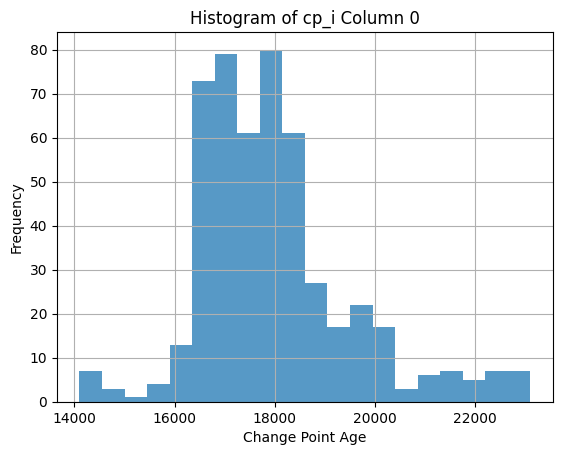

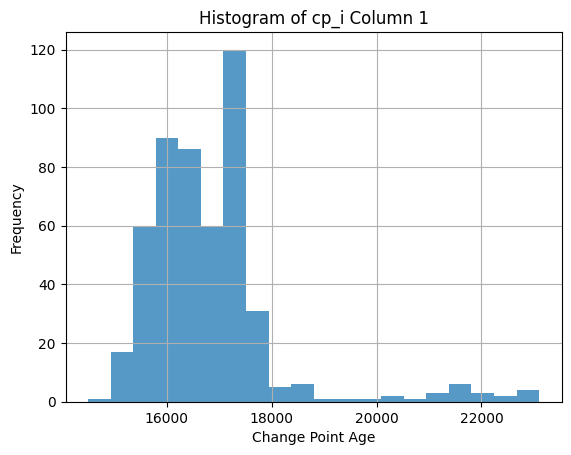

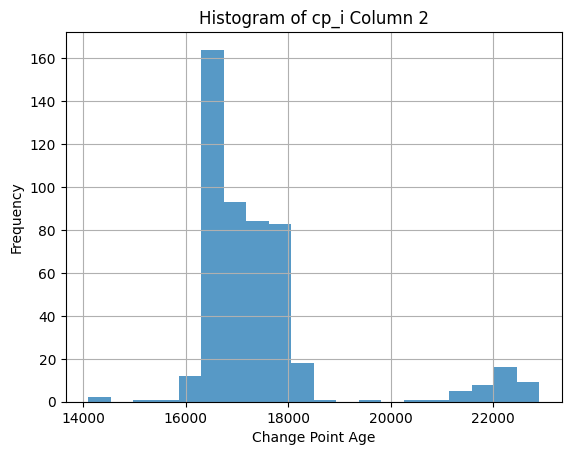

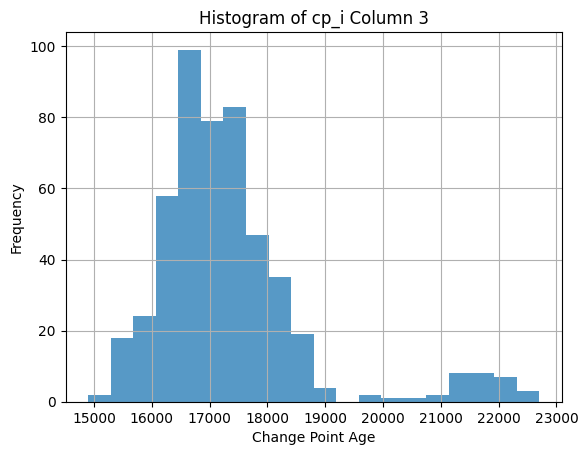

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Convert all_cp_i to a NumPy array
all_cp_i_array = np.array(all_cp_i)

# Check the shape to see if all_cp_i is a 2D array (which is required for this operation)
print("Shape of all_cp_i_array:", all_cp_i_array.shape)

# Plot histograms of the columns of all_cp_i_array
num_columns = all_cp_i_array.shape[1]
for idx in range(num_columns):
    plt.figure()  # Create a new figure for each histogram
    plt.hist(all_cp_i_array[:, idx], bins=20, alpha=0.75)  # Adjust the number of bins as needed
    plt.title(f'Histogram of cp_i Column {idx}')
    plt.xlabel('Change Point Age')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [ ]:
import numpy as np
from toolbox import change_point_functions as cpf


sat_shape=ds_sat['sat'].isel(nEns=0).shape

for i in range(len(ds_sat['nEns'])):
    # Select the ensemble member
    ds_sat_i = ds_sat.isel(nEns=i)
    
    ds_sat_i['class_label'] = (('lat', 'lon'), labels_Ens_aligned[i]['labels'].reshape(sat_shape[1], sat_shape[2]))
    weighted_avg_curves = {}
    
    for j in range(len(np.unique(labels_Ens_aligned[i]['labels']))):
        weighted_avg_curves[j]=cal_weighted_average_curve(ds_sat_i, j)


    cp_i=[]
    for k in range(len(weighted_avg_curves)):
        cp_climo_info=cpf.find_cp(weighted_avg_curves[k], ds_sat['age'].values, avg_plot=False)
        cp_i[k]=cp_climo_info['cp_age']




# Measure the consistency of results

In [19]:
import numpy as np
def measure_consistency(labels,threshold_of_consistency=0.05):
    """
    Measure the consistency of label assignments compared to the first iteration.

    Parameters:
    - labels: List of dictionaries, each containing a 'labels' key with numpy array of labels.

    Returns:
    - consistency_ratio: Proportion of iterations where labels are consistent with the first iteration.
    """

    reference_labels = labels[0]['labels']
    n_samples = len(reference_labels)
    print('n_samples=',n_samples)
    threshold = threshold_of_consistency * n_samples  # 5% of the total samples
    print('threshold=',threshold)
    
    consistent_iterations = 0

    for result in labels:
        # Compute the number of differing labels compared to the reference
        diff_labels_count = np.sum(result['labels'] != reference_labels)
        print('diff_labels_count',diff_labels_count)
        
        if diff_labels_count <= threshold:
            consistent_iterations += 1

    consistency_ratio = consistent_iterations / len(labels)
    
    return consistency_ratio




In [41]:
consistency_ratio = measure_consistency(labels_Ens_aligned, threshold_of_consistency=0.05)
print(f"Proportion of iterations where labels are consistent with the first iteration: {consistency_ratio:.2f}")

n_samples= 13824
threshold= 691.2
diff_labels_count 0
diff_labels_count 5389
diff_labels_count 4527
diff_labels_count 2055
diff_labels_count 3128
diff_labels_count 2712
diff_labels_count 6203
diff_labels_count 1928
diff_labels_count 5977
diff_labels_count 4101
diff_labels_count 2135
diff_labels_count 2920
diff_labels_count 7071
diff_labels_count 1778
diff_labels_count 1111
diff_labels_count 1735
diff_labels_count 1619
diff_labels_count 1490
diff_labels_count 1586
diff_labels_count 2710
diff_labels_count 3064
diff_labels_count 1635
diff_labels_count 4241
diff_labels_count 3443
diff_labels_count 2860
diff_labels_count 3827
diff_labels_count 5676
diff_labels_count 2725
diff_labels_count 2676
diff_labels_count 3930
diff_labels_count 5033
diff_labels_count 1503
diff_labels_count 2417
diff_labels_count 2828
diff_labels_count 6312
diff_labels_count 6723
diff_labels_count 4564
diff_labels_count 4658
diff_labels_count 4153
diff_labels_count 4920
diff_labels_count 7078
diff_labels_count 1964
dif